# Biweekly Report 3
# Kyle, Carney
## Augmentation

In this biweekly report I will explore the effect of data augmentation on the accuracy of a CNN model trained to identify 12 species of mushrooms. I find that data augmentation can greatly hinder or improve the performance of a model. In this report I train a model on a variety of datasets that have been modified by common augmented methods. This particular dataset is very sensitive to color changes so augmentation methods that effect the color tend to decrease model accuracy. However, methods that preserve color such as rotation and cropping significantly improve model accuracy. Furthermore, I study the effect of combining multiple methods. This is a continuation of my second biweekly report where I determined the optimization function that works best on this dataset.

## Background of Dataset

I am using the mushroom dataset curated by Dr. Boyuan Wang and available at [https://www.kaggle.com/mustai/mushroom-12-9528](https://www.kaggle.com/mustai/mushroom-12-9528). The dataset contains 9528 images of 12 different species of mushroom.  The accuracy of the data and labels has been confirmed by the Nordic Association of Mycologists. Previously studies have successfully used this dataset to train accurate models based on convolutional neural network architectures [https://doi.org/10.1155/2022/1173102](https://doi.org/10.1155/2022/1173102). Therefore, this dataset is accurate and of a high enough quality that it can be used to train my convolutional neural networks. This dataset is not fully balanced with Pluteus and Exidia being underrepresented.

In [1]:
#import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
#project name
project_name = 'mushroom-species-classification'

In [3]:
#train and test data directory
data_dir = "Mushroom_data/train"
test_data_dir = "Mushroom_data/test"

# Simple Augmentation Methods

I am interested to see how the data responds to a variety of simple augmentation techniques. Therefore, I will consider the performance of a model that has been adjusted by a variety of methods. The gray transform has a 50% chance of converting an image to gray scale. The crop transformation will randomly focus in on a random portion of an image. The rotation transform will rotate an image by a random angle between 0 and 2pi. The flip transformation will randomly flip an image horizontally. The jitter transformation randomly changes an image's brightness, saturation, contrast and hue. The blur transformation reduces image sharpness using a random kernel size. All datasets are normalized to ensure they have zero mean and unit variance.

In [4]:
#non-normalized transform for image display
Vanilla_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # to-tensor
    transforms.ToTensor()
])

#just normalized transform
Base_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])

#random grayscale transform
Gray_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # randomly apply grayscale
    transforms.RandomGrayscale(p=0.5),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])

#random crop transform
Crop_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # rand crop
    transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])

#Rotation transform
Rotation_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # apply random rotation
    transforms.RandomRotation(degrees=360),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])

#Flip transform
Flip_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # randomly apply flip
    transforms.RandomHorizontalFlip(p=0.5),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])

#random color jitter transform
Jitter_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # color jitter
    transforms.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])

#random blur transform
Blur_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # apply Gaussian noise
    transforms.GaussianBlur(kernel_size=(49, 75), sigma=(0.1,0.2) ),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])


In [5]:
#load the train and test data
vanilla_dataset = ImageFolder(data_dir,Vanilla_transform)
base_dataset = ImageFolder(data_dir,Base_transform)
gray_dataset = ImageFolder(data_dir,Gray_transform)
crop_dataset = ImageFolder(data_dir,Crop_transform)
rotation_dataset = ImageFolder(data_dir,Rotation_transform)
flip_dataset = ImageFolder(data_dir,Flip_transform)
jitter_dataset = ImageFolder(data_dir,Jitter_transform)
blur_dataset = ImageFolder(data_dir,Blur_transform)

test_dataset = ImageFolder(test_data_dir,Base_transform)

## Example of image transformations

I will now display a few sample images that have been affected by each of the transforms we will be using to train our models. For clarity we apply these transforms to a non-normalized image.

In [6]:
orig_img, label = vanilla_dataset[4010]
orig_img = transforms.ToPILImage()(orig_img)


gray_img = transforms.RandomGrayscale(p=1)(orig_img)

#resized_imgs = transforms.Resize(size=150)(orig_img)
cropped_img = transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333))(orig_img)
rotated_img = transforms.RandomRotation(degrees=360)(orig_img)
flipped_img =  transforms.RandomHorizontalFlip(p=1.0)(orig_img)
jitter_img = transforms.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1)(orig_img)
blurred_img =  transforms.GaussianBlur(kernel_size=(49, 75), sigma= 1)(orig_img)


normalized_img = transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])(transforms.ToTensor()(orig_img))
normalized_img = transforms.ToPILImage()(normalized_img)

sample_images = [orig_img,gray_img,cropped_img, rotated_img, flipped_img, jitter_img, blurred_img, normalized_img]
labels = ["original","gray" ,"cropped","rotated","flipped","color jitter", " blurred", "normalized"]

C:\Users\kyle\AppData\Local\Programs\Python\Python310\lib\site-packages\ipyplot\_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



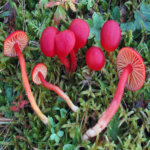
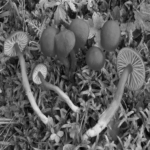
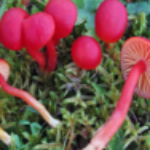
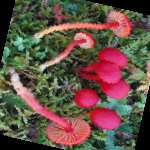
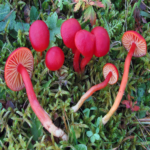
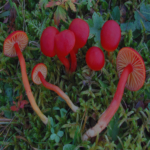
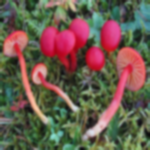
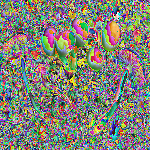


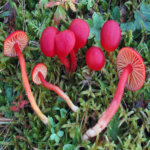
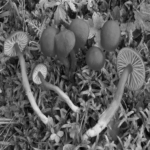
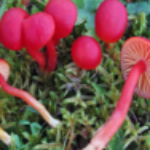
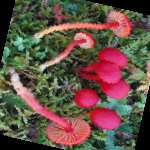
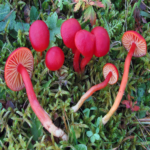
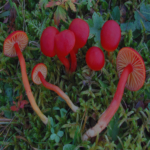
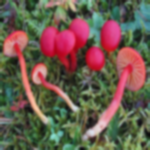
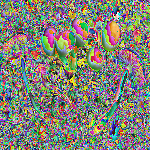

In [7]:
import ipyplot

ipyplot.plot_images(sample_images, labels, max_images=9, img_width=150)

## Split Data and Define Dataloaders

I will now split the full dataset into training and validation data. Since I am working with a relatively small dataset I reserve 20% of the data for validation.

In [8]:
val_size = int(np.floor(0.2 * len(base_dataset)))
train_size = len(base_dataset) - val_size

vanilla_train_data,vanilla_val_data = random_split(vanilla_dataset,[train_size,val_size])
base_train_data,base_val_data = random_split(base_dataset,[train_size,val_size])
gray_train_data,gray_val_data = random_split(gray_dataset,[train_size,val_size])
crop_train_data,crop_val_data = random_split(crop_dataset,[train_size,val_size])
rotation_train_data,rotation_val_data = random_split(rotation_dataset,[train_size,val_size])
flip_train_data,flip_val_data = random_split(flip_dataset,[train_size,val_size])
jitter_train_data,jitter_val_data = random_split(jitter_dataset,[train_size,val_size])
blur_train_data,blur_val_data = random_split(blur_dataset,[train_size,val_size])

print(f"Length of Train Data : {len(base_train_data)}")
print(f"Length of Validation Data : {len(base_val_data)}")

Length of Train Data : 6094
Length of Validation Data : 1523


In [9]:
batch_size = 64

In [10]:
#load the train and validation into batches.
vanilla_train_dl = DataLoader(vanilla_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
vanilla_val_dl = DataLoader(vanilla_val_data, batch_size*2, num_workers = 4, pin_memory = True)

base_train_dl = DataLoader(base_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
base_val_dl = DataLoader(base_val_data, batch_size*2, num_workers = 4, pin_memory = True)

gray_train_dl = DataLoader(gray_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
gray_val_dl = DataLoader(gray_val_data, batch_size*2, num_workers = 4, pin_memory = True)


crop_train_dl = DataLoader(crop_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
crop_val_dl = DataLoader(crop_val_data, batch_size*2, num_workers = 4, pin_memory = True)

rotation_train_dl = DataLoader(rotation_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
rotation_val_dl = DataLoader(rotation_val_data, batch_size*2, num_workers = 4, pin_memory = True)

flip_train_dl = DataLoader(flip_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
flip_val_dl = DataLoader(flip_val_data, batch_size*2, num_workers = 4, pin_memory = True)

jitter_train_dl = DataLoader(jitter_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
jitter_val_dl = DataLoader(jitter_val_data, batch_size*2, num_workers = 4, pin_memory = True)

blur_train_dl = DataLoader(blur_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
blur_val_dl = DataLoader(blur_val_data, batch_size*2, num_workers = 4, pin_memory = True)

## Check Normalization

I will now check to see that I used the correct mean and standard deviation to normalize the dataset. Ideally, the normalized dataset should have mean 0 and standard deviation 1. Since I split randomly split the dataset it is unlikely that the training and validation datasets will be exactly these values. However, as long as the mean is reasonably close to 0 and the standard deviation is near 1 then the model will still benefit from normalization.

In [11]:
def batch_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)
    return mean,std

In [12]:
train_mean, train_std = batch_mean_and_sd(vanilla_train_dl)
print("original training data mean and std:", train_mean, train_std)
val_mean, val_std = batch_mean_and_sd(vanilla_val_dl)
print("original validation data mean and std:", val_mean, val_std )

original training data mean and std: tensor([0.4082, 0.3871, 0.3000]) tensor([0.2469, 0.2266, 0.2276])
original validation data mean and std: tensor([0.4065, 0.3832, 0.2938]) tensor([0.2491, 0.2265, 0.2254])


In [13]:
train_mean, train_std = batch_mean_and_sd(base_train_dl)
print("normalized training data mean and std:", train_mean, train_std)
val_mean, val_std = batch_mean_and_sd(base_val_dl)
print("normalized validation data mean and std:", val_mean, val_std )

normalized training data mean and std: tensor([-0.0022, -0.0021, -0.0091]) tensor([0.9995, 0.9966, 0.9963])
normalized validation data mean and std: tensor([0.0093, 0.0015, 0.0009]) tensor([1.0025, 0.9976, 0.9980])


## Model Definition

I use a model with 6 convolutional layers and 3 fully connected layers. In order to increase accuracy and prevent overfitting I also use batch normalization and a 10% dropout between the convolution layers.

In [14]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class MushroomSpeciesClassification(ImageClassificationBase):

    def __init__(self):

        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1),


            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1),


            nn.Conv2d(128,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256 ,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,12)
        )

    def forward(self, xb):
        return self.network(xb)

## Load Data into Device

I will now define the functions and classes that will be used to set and load data into the device.

In [16]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
# load the into GPU
base_train_dl = DeviceDataLoader(base_train_dl, device)
base_val_dl = DeviceDataLoader(base_val_dl, device)

gray_train_dl = DeviceDataLoader(gray_train_dl, device)
gray_val_dl = DeviceDataLoader(gray_val_dl, device)

crop_train_dl = DeviceDataLoader(crop_train_dl, device)
crop_val_dl = DeviceDataLoader(crop_val_dl, device)

rotation_train_dl = DeviceDataLoader(rotation_train_dl, device)
rotation_val_dl = DeviceDataLoader(rotation_val_dl, device)

flip_train_dl = DeviceDataLoader(flip_train_dl, device)
flip_val_dl = DeviceDataLoader(flip_val_dl, device)

jitter_train_dl = DeviceDataLoader(jitter_train_dl, device)
jitter_val_dl = DeviceDataLoader(jitter_val_dl, device)

blur_train_dl = DeviceDataLoader(blur_train_dl, device)
blur_val_dl = DeviceDataLoader(blur_val_dl, device)

## Define Training Functions

These are standard model training functions.

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    acc_history = []

    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)


        acc_history.append(result)

    return acc_history

In [20]:
#load the model to the device

base_model = to_device(MushroomSpeciesClassification(),device)
gray_model = to_device(MushroomSpeciesClassification(),device)
crop_model = to_device(MushroomSpeciesClassification(),device)
rotation_model = to_device(MushroomSpeciesClassification(),device)
flip_model = to_device(MushroomSpeciesClassification(),device)
jitter_model = to_device(MushroomSpeciesClassification(),device)
blur_model = to_device(MushroomSpeciesClassification(),device)

## Model Training
I will now train the model over 36 epochs. I chose this number of epochs since it is 3 times the number of classes. I am using Adamax since my previous biweekly report found this optimizer tends to preform very well on this dataset when the learning rate is 0.001.

In [21]:
#set the no. of epochs, optimizer function and learning rate
num_epochs = 36
opt_func = torch.optim.Adamax
lr = 0.001

In [22]:
#fitting the model on training data and record the result after each epoch
base_acc_history = fit(num_epochs, lr, base_model, base_train_dl, base_val_dl, opt_func)

Epoch [0], train_loss: 2.1967, val_loss: 2.1453, val_acc: 0.2946
Epoch [1], train_loss: 1.7783, val_loss: 1.9235, val_acc: 0.3845
Epoch [2], train_loss: 1.3964, val_loss: 1.9268, val_acc: 0.4073
Epoch [3], train_loss: 0.7799, val_loss: 2.2575, val_acc: 0.3762
Epoch [4], train_loss: 0.3503, val_loss: 2.3593, val_acc: 0.3712
Epoch [5], train_loss: 0.1430, val_loss: 2.4808, val_acc: 0.3895
Epoch [6], train_loss: 0.0934, val_loss: 2.4530, val_acc: 0.4074
Epoch [7], train_loss: 0.0922, val_loss: 2.3964, val_acc: 0.3962
Epoch [8], train_loss: 0.0488, val_loss: 2.4431, val_acc: 0.4100
Epoch [9], train_loss: 0.0332, val_loss: 2.4439, val_acc: 0.4041
Epoch [10], train_loss: 0.0238, val_loss: 2.4694, val_acc: 0.3960
Epoch [11], train_loss: 0.0150, val_loss: 2.5329, val_acc: 0.4062
Epoch [12], train_loss: 0.0166, val_loss: 2.7325, val_acc: 0.4005
Epoch [13], train_loss: 0.0083, val_loss: 2.5619, val_acc: 0.4119
Epoch [14], train_loss: 0.0074, val_loss: 2.5544, val_acc: 0.4151
Epoch [15], train_lo

In [23]:
#fitting the model on training data and record the result after each epoch
gray_acc_history  = fit(num_epochs, lr, gray_model, gray_train_dl, gray_val_dl, opt_func)

Epoch [0], train_loss: 2.2698, val_loss: 2.1756, val_acc: 0.2699
Epoch [1], train_loss: 1.9543, val_loss: 2.0556, val_acc: 0.3036
Epoch [2], train_loss: 1.6912, val_loss: 2.0316, val_acc: 0.3035
Epoch [3], train_loss: 1.2515, val_loss: 2.1802, val_acc: 0.3189
Epoch [4], train_loss: 0.6219, val_loss: 2.3703, val_acc: 0.3377
Epoch [5], train_loss: 0.2197, val_loss: 2.3139, val_acc: 0.3643
Epoch [6], train_loss: 0.0968, val_loss: 2.4968, val_acc: 0.3638
Epoch [7], train_loss: 0.0528, val_loss: 2.4964, val_acc: 0.3624
Epoch [8], train_loss: 0.0311, val_loss: 2.4994, val_acc: 0.3619
Epoch [9], train_loss: 0.0184, val_loss: 2.6544, val_acc: 0.3606
Epoch [10], train_loss: 0.0187, val_loss: 2.6340, val_acc: 0.3626
Epoch [11], train_loss: 0.0425, val_loss: 2.8484, val_acc: 0.3450
Epoch [12], train_loss: 0.0383, val_loss: 2.8739, val_acc: 0.3371
Epoch [13], train_loss: 0.0222, val_loss: 2.8479, val_acc: 0.3455
Epoch [14], train_loss: 0.0115, val_loss: 2.8822, val_acc: 0.3443
Epoch [15], train_lo

In [24]:
#fitting the model on training data and record the result after each epoch
crop_acc_history = fit(num_epochs, lr, crop_model, crop_train_dl, crop_val_dl, opt_func)

Epoch [0], train_loss: 2.3323, val_loss: 2.2566, val_acc: 0.2346
Epoch [1], train_loss: 2.1328, val_loss: 2.1170, val_acc: 0.2893
Epoch [2], train_loss: 2.0516, val_loss: 2.0938, val_acc: 0.2993
Epoch [3], train_loss: 1.9590, val_loss: 1.9791, val_acc: 0.3322
Epoch [4], train_loss: 1.9071, val_loss: 1.9893, val_acc: 0.3381
Epoch [5], train_loss: 1.8314, val_loss: 1.9097, val_acc: 0.3584
Epoch [6], train_loss: 1.7966, val_loss: 1.9085, val_acc: 0.3646
Epoch [7], train_loss: 1.7356, val_loss: 1.8905, val_acc: 0.3787
Epoch [8], train_loss: 1.6978, val_loss: 1.8627, val_acc: 0.3790
Epoch [9], train_loss: 1.6463, val_loss: 1.7757, val_acc: 0.3915
Epoch [10], train_loss: 1.6113, val_loss: 1.8375, val_acc: 0.3852
Epoch [11], train_loss: 1.5469, val_loss: 1.8528, val_acc: 0.3661
Epoch [12], train_loss: 1.5120, val_loss: 1.7596, val_acc: 0.4028
Epoch [13], train_loss: 1.4592, val_loss: 1.7731, val_acc: 0.4328
Epoch [14], train_loss: 1.4149, val_loss: 1.7337, val_acc: 0.4284
Epoch [15], train_lo

In [25]:
#fitting the model on training data and record the result after each epoch
rotation_acc_history = fit(num_epochs, lr, rotation_model, rotation_train_dl, rotation_val_dl, opt_func)

Epoch [0], train_loss: 2.2987, val_loss: 2.1304, val_acc: 0.2705
Epoch [1], train_loss: 2.0332, val_loss: 2.0008, val_acc: 0.3390
Epoch [2], train_loss: 1.9414, val_loss: 1.9046, val_acc: 0.3713
Epoch [3], train_loss: 1.8492, val_loss: 1.8355, val_acc: 0.3887
Epoch [4], train_loss: 1.7577, val_loss: 1.8926, val_acc: 0.3635
Epoch [5], train_loss: 1.7162, val_loss: 1.8090, val_acc: 0.4112
Epoch [6], train_loss: 1.6372, val_loss: 1.8091, val_acc: 0.3971
Epoch [7], train_loss: 1.5700, val_loss: 1.7451, val_acc: 0.4161
Epoch [8], train_loss: 1.5296, val_loss: 1.7404, val_acc: 0.4127
Epoch [9], train_loss: 1.5089, val_loss: 1.6415, val_acc: 0.4473
Epoch [10], train_loss: 1.4197, val_loss: 1.7076, val_acc: 0.4460
Epoch [11], train_loss: 1.3826, val_loss: 1.6241, val_acc: 0.4682
Epoch [12], train_loss: 1.2849, val_loss: 1.6175, val_acc: 0.4622
Epoch [13], train_loss: 1.2520, val_loss: 1.6205, val_acc: 0.4750
Epoch [14], train_loss: 1.1864, val_loss: 1.6453, val_acc: 0.4774
Epoch [15], train_lo

In [26]:
#fitting the model on training data and record the result after each epoch
flip_acc_history  = fit(num_epochs, lr, flip_model, flip_train_dl, flip_val_dl, opt_func)

Epoch [0], train_loss: 2.2239, val_loss: 2.1833, val_acc: 0.2780
Epoch [1], train_loss: 1.8784, val_loss: 2.1108, val_acc: 0.3084
Epoch [2], train_loss: 1.6766, val_loss: 1.9385, val_acc: 0.3784
Epoch [3], train_loss: 1.4176, val_loss: 1.9260, val_acc: 0.3863
Epoch [4], train_loss: 1.1706, val_loss: 1.9112, val_acc: 0.4182
Epoch [5], train_loss: 0.9060, val_loss: 1.9263, val_acc: 0.4310
Epoch [6], train_loss: 0.6648, val_loss: 2.1484, val_acc: 0.3929
Epoch [7], train_loss: 0.5131, val_loss: 2.3536, val_acc: 0.3933
Epoch [8], train_loss: 0.4357, val_loss: 2.1602, val_acc: 0.4309
Epoch [9], train_loss: 0.3134, val_loss: 2.2044, val_acc: 0.4273
Epoch [10], train_loss: 0.1754, val_loss: 2.2073, val_acc: 0.4406
Epoch [11], train_loss: 0.1259, val_loss: 2.2896, val_acc: 0.4275
Epoch [12], train_loss: 0.0851, val_loss: 2.3181, val_acc: 0.4360
Epoch [13], train_loss: 0.0582, val_loss: 2.4189, val_acc: 0.4270
Epoch [14], train_loss: 0.0483, val_loss: 2.3799, val_acc: 0.4345
Epoch [15], train_lo

In [27]:
#fitting the model on training data and record the result after each epoch
jitter_acc_history  = fit(num_epochs, lr, jitter_model, jitter_train_dl, jitter_val_dl, opt_func)

Epoch [0], train_loss: 2.4691, val_loss: 2.3871, val_acc: 0.1531
Epoch [1], train_loss: 2.3090, val_loss: 2.2856, val_acc: 0.2252
Epoch [2], train_loss: 2.2212, val_loss: 2.2511, val_acc: 0.2302
Epoch [3], train_loss: 2.1509, val_loss: 2.1637, val_acc: 0.2607
Epoch [4], train_loss: 2.0845, val_loss: 2.1592, val_acc: 0.2523
Epoch [5], train_loss: 1.9882, val_loss: 2.1471, val_acc: 0.2736
Epoch [6], train_loss: 1.8415, val_loss: 2.1348, val_acc: 0.3005
Epoch [7], train_loss: 1.6085, val_loss: 2.1897, val_acc: 0.2837
Epoch [8], train_loss: 1.2500, val_loss: 2.3846, val_acc: 0.2869
Epoch [9], train_loss: 0.8149, val_loss: 2.4078, val_acc: 0.3102
Epoch [10], train_loss: 0.4745, val_loss: 2.6421, val_acc: 0.2925
Epoch [11], train_loss: 0.3457, val_loss: 2.8561, val_acc: 0.2834
Epoch [12], train_loss: 0.2637, val_loss: 2.7655, val_acc: 0.2787
Epoch [13], train_loss: 0.1922, val_loss: 2.8177, val_acc: 0.2992
Epoch [14], train_loss: 0.1355, val_loss: 2.8085, val_acc: 0.3041
Epoch [15], train_lo

In [28]:
#fitting the model on training data and record the result after each epoch
blur_acc_history = fit(num_epochs, lr, blur_model, blur_train_dl, blur_val_dl, opt_func)

Epoch [0], train_loss: 2.1164, val_loss: 1.9893, val_acc: 0.3299
Epoch [1], train_loss: 1.6607, val_loss: 1.8676, val_acc: 0.3847
Epoch [2], train_loss: 1.2091, val_loss: 1.9242, val_acc: 0.3884
Epoch [3], train_loss: 0.6567, val_loss: 2.0527, val_acc: 0.4007
Epoch [4], train_loss: 0.2847, val_loss: 2.1722, val_acc: 0.4084
Epoch [5], train_loss: 0.1034, val_loss: 2.1746, val_acc: 0.4125
Epoch [6], train_loss: 0.0471, val_loss: 2.2026, val_acc: 0.4137
Epoch [7], train_loss: 0.0281, val_loss: 2.1783, val_acc: 0.4253
Epoch [8], train_loss: 0.0147, val_loss: 2.2586, val_acc: 0.4254
Epoch [9], train_loss: 0.0093, val_loss: 2.2541, val_acc: 0.4256
Epoch [10], train_loss: 0.0135, val_loss: 2.3280, val_acc: 0.4378
Epoch [11], train_loss: 0.0118, val_loss: 2.4267, val_acc: 0.4143
Epoch [12], train_loss: 0.0084, val_loss: 2.4896, val_acc: 0.4244
Epoch [13], train_loss: 0.0126, val_loss: 2.3961, val_acc: 0.4409
Epoch [14], train_loss: 0.0041, val_loss: 2.3774, val_acc: 0.4321
Epoch [15], train_lo

## Results
I will now consider how the validation accuracy varies by model.

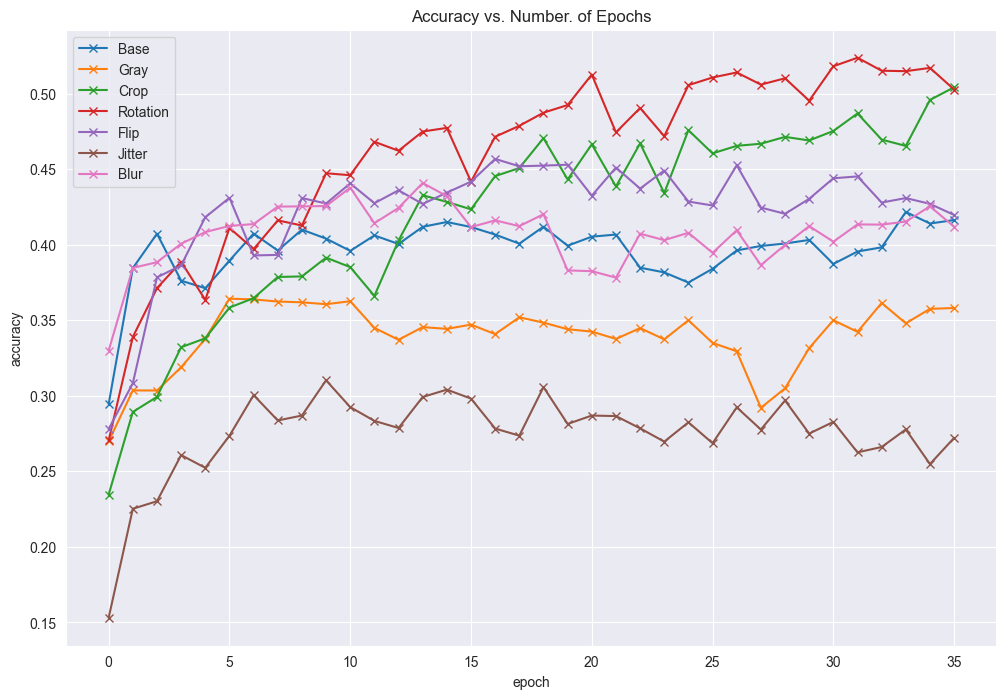

In [66]:
def plot_accuracies(base_history,crop_history,rotation_history,flip_history,jitter_history,blur_history,noise_history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in base_history]
    plt.plot(accuracies, '-x', label = 'Base')
    accuracies = [x['val_acc'] for x in crop_history]
    plt.plot(accuracies, '-x', label = 'Gray')
    accuracies = [x['val_acc'] for x in rotation_history]
    plt.plot(accuracies, '-x', label = 'Crop')
    accuracies = [x['val_acc'] for x in flip_history]
    plt.plot(accuracies, '-x', label = 'Rotation')
    accuracies = [x['val_acc'] for x in jitter_history]
    plt.plot(accuracies, '-x', label = 'Flip')
    accuracies = [x['val_acc'] for x in blur_history]
    plt.plot(accuracies, '-x', label = 'Jitter')
    accuracies = [x['val_acc'] for x in noise_history]
    plt.plot(accuracies, '-x', label = 'Blur')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. Number. of Epochs');
    plt.legend()
    plt.rcParams["figure.figsize"] = (12,8)

plot_accuracies(base_acc_history,gray_acc_history,crop_acc_history,rotation_acc_history,flip_acc_history,jitter_acc_history,blur_acc_history)

These results suggest the rotation transformation is particularly good at augmenting the data as it produced the highest accuracy. Indeed, every time I ran this analysis the model trained with the rotation dataset always had one of the highest final accuracy. I suspect this because the rotation transformation preserves image color while changing the images enough to avoid overfitting. The crop model performs well for similar reasons.

## Analysis of Best and Worst Performing Models
In order to gain a better insight into what drives model accuracy I will now compare the confusion matrices for the best performing model (rotation) and the worst performing model (jitter).

In [68]:
test_dl = DataLoader(test_dataset, 2*batch_size, num_workers = 4, pin_memory = True)
test_dl = DeviceDataLoader(test_dl, device)


from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_dl:
        output = rotation_model(images) # Feed Model

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


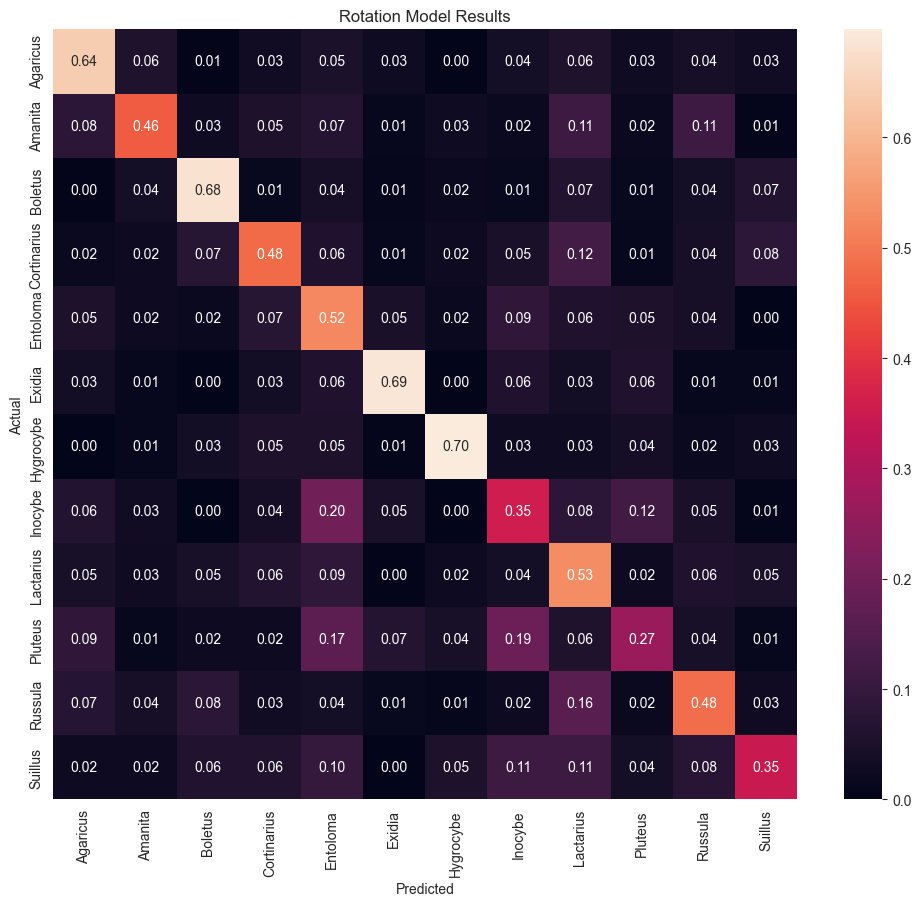

In [69]:
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,10))

sn.heatmap(cmn, annot = True, fmt = '.2f', xticklabels= base_dataset.classes, yticklabels= base_dataset.classes )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Rotation Model Results')
plt.show(block = False)

This is the confusion matrix for the model with the highest validation accuracy i.e. the rotation model. This confusion matrix is very encouraging as it shows that the model accuracy is largely held back by a few classes.

In [55]:
y_pred = []
y_true = []

# iterate over test data
for images, labels in test_dl:
        output = jitter_model(images) # Feed Model

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

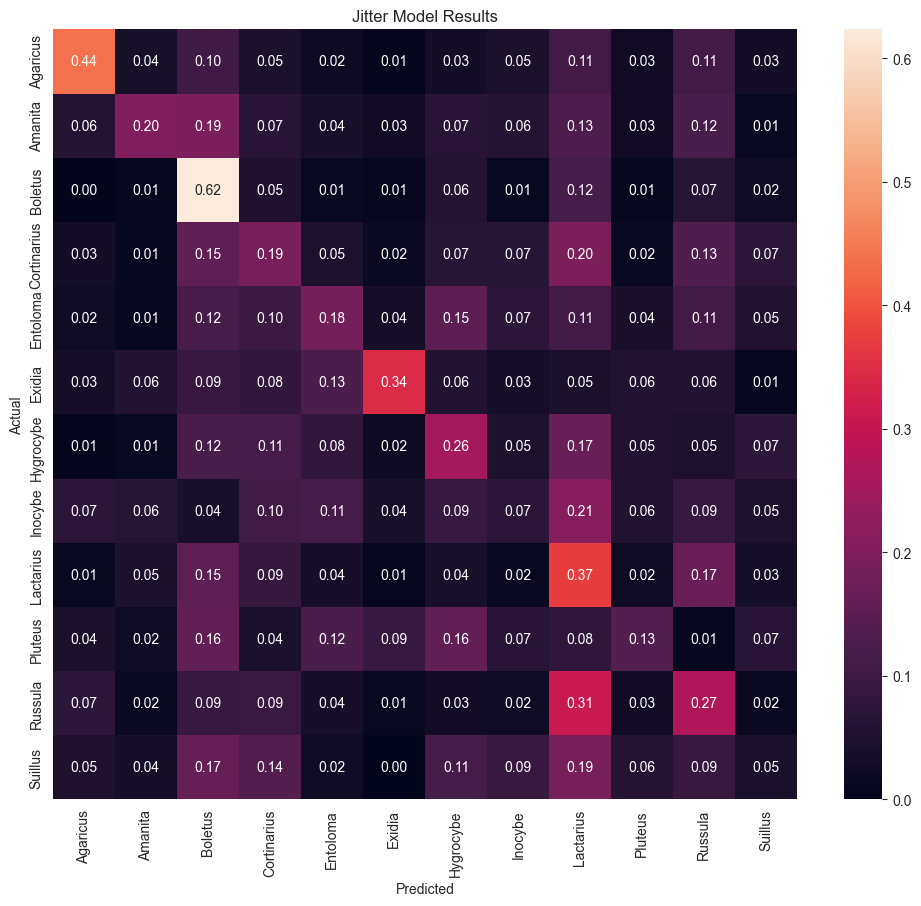

In [56]:
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,10))

sn.heatmap(cmn, annot = True, fmt = '.2f', xticklabels= base_dataset.classes, yticklabels= base_dataset.classes )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Jitter Model Results')
plt.show(block = False)

This is the confusion matrix for the model with the lowest validation accuracy i.e. the jitter model. It appears that color jitter model only has a relatively high accuracy in one class. This suggests that color is an important trait for species identification.

# Compound Augmentations
I am curious to see if combining augmentation will drastically increase the model accuracy. Therefore, I will train additional models with data that has been augmented with the top 2 and top 3 performing transformation methods. Based on my previous work the top 2 performing transforms are rotation and cropping. Similarly, the top 3 transforms are rotation, cropping, and flipping. To this end, I will reuse my code from the previous sections to train two additional models.

In [57]:
#non-normalized transform for image display
Top2_transforms = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # rand crop
    transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    # apply random rotation
    transforms.RandomRotation(degrees=360),
    # to-tensor
    transforms.ToTensor()
])

Top3_transforms = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # rand crop
    transforms.RandomResizedCrop(150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    # apply random rotation
    transforms.RandomRotation(degrees=360),
    # randomly apply flip
    transforms.RandomHorizontalFlip(p=0.5),
    # to-tensor
    transforms.ToTensor()
])

In [58]:
#load the train and test data
Top2_dataset = ImageFolder(data_dir,Top2_transforms)
Top3_dataset = ImageFolder(data_dir,Top3_transforms)

In [59]:
Top2_train_data,Top2_val_data = random_split(Top2_dataset,[train_size,val_size])
Top3_train_data,Top3_val_data = random_split(Top3_dataset,[train_size,val_size])

In [60]:
Top2_train_dl = DataLoader(Top2_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
Top2_val_dl = DataLoader(Top2_val_data, batch_size*2, num_workers = 4, pin_memory = True)

Top3_train_dl = DataLoader(Top3_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
Top3_val_dl = DataLoader(Top3_val_data, batch_size*2, num_workers = 4, pin_memory = True)

In [61]:
Top2_train_dl = DeviceDataLoader(Top2_train_dl, device)
Top2_val_dl = DeviceDataLoader(Top2_val_dl, device)

Top3_train_dl = DeviceDataLoader(Top3_train_dl, device)
Top3_val_dl = DeviceDataLoader(Top3_val_dl, device)

In [40]:
Top2_model = to_device(MushroomSpeciesClassification(),device)
Top3_model = to_device(MushroomSpeciesClassification(),device)

In [41]:
#fitting the model on training data and record the result after each epoch
Top2_acc_history = fit(num_epochs, lr, Top2_model, Top2_train_dl, Top2_val_dl, opt_func)

Epoch [0], train_loss: 2.3521, val_loss: 2.2138, val_acc: 0.2575
Epoch [1], train_loss: 2.1551, val_loss: 2.1886, val_acc: 0.2849
Epoch [2], train_loss: 2.0666, val_loss: 2.0512, val_acc: 0.3148
Epoch [3], train_loss: 1.9778, val_loss: 2.0142, val_acc: 0.3097
Epoch [4], train_loss: 1.9071, val_loss: 1.9528, val_acc: 0.3659
Epoch [5], train_loss: 1.8217, val_loss: 1.8743, val_acc: 0.3693
Epoch [6], train_loss: 1.7945, val_loss: 1.9271, val_acc: 0.3625
Epoch [7], train_loss: 1.7543, val_loss: 2.4308, val_acc: 0.2610
Epoch [8], train_loss: 1.7092, val_loss: 1.9019, val_acc: 0.3739
Epoch [9], train_loss: 1.6321, val_loss: 1.8566, val_acc: 0.3693
Epoch [10], train_loss: 1.6089, val_loss: 1.9283, val_acc: 0.3784
Epoch [11], train_loss: 1.5656, val_loss: 1.9568, val_acc: 0.3727
Epoch [12], train_loss: 1.5407, val_loss: 1.9041, val_acc: 0.3662
Epoch [13], train_loss: 1.4727, val_loss: 1.8389, val_acc: 0.4065
Epoch [14], train_loss: 1.4138, val_loss: 1.9185, val_acc: 0.3559
Epoch [15], train_lo

In [42]:
#fitting the model on training data and record the result after each epoch
Top3_acc_history = fit(num_epochs, lr, Top3_model, Top3_train_dl, Top3_val_dl, opt_func)

Epoch [0], train_loss: 2.3108, val_loss: 2.2171, val_acc: 0.2734
Epoch [1], train_loss: 2.1001, val_loss: 2.1012, val_acc: 0.3101
Epoch [2], train_loss: 2.0182, val_loss: 2.0901, val_acc: 0.3113
Epoch [3], train_loss: 1.9503, val_loss: 1.9998, val_acc: 0.3241
Epoch [4], train_loss: 1.9078, val_loss: 2.0580, val_acc: 0.3263
Epoch [5], train_loss: 1.8619, val_loss: 1.9473, val_acc: 0.3595
Epoch [6], train_loss: 1.8320, val_loss: 1.9126, val_acc: 0.3561
Epoch [7], train_loss: 1.7517, val_loss: 1.8880, val_acc: 0.3574
Epoch [8], train_loss: 1.7392, val_loss: 1.8087, val_acc: 0.4108
Epoch [9], train_loss: 1.6975, val_loss: 1.8272, val_acc: 0.3866
Epoch [10], train_loss: 1.6683, val_loss: 1.8155, val_acc: 0.3746
Epoch [11], train_loss: 1.6332, val_loss: 1.8107, val_acc: 0.3966
Epoch [12], train_loss: 1.5647, val_loss: 1.7449, val_acc: 0.4177
Epoch [13], train_loss: 1.5502, val_loss: 1.7971, val_acc: 0.4122
Epoch [14], train_loss: 1.5161, val_loss: 1.7643, val_acc: 0.4251
Epoch [15], train_lo

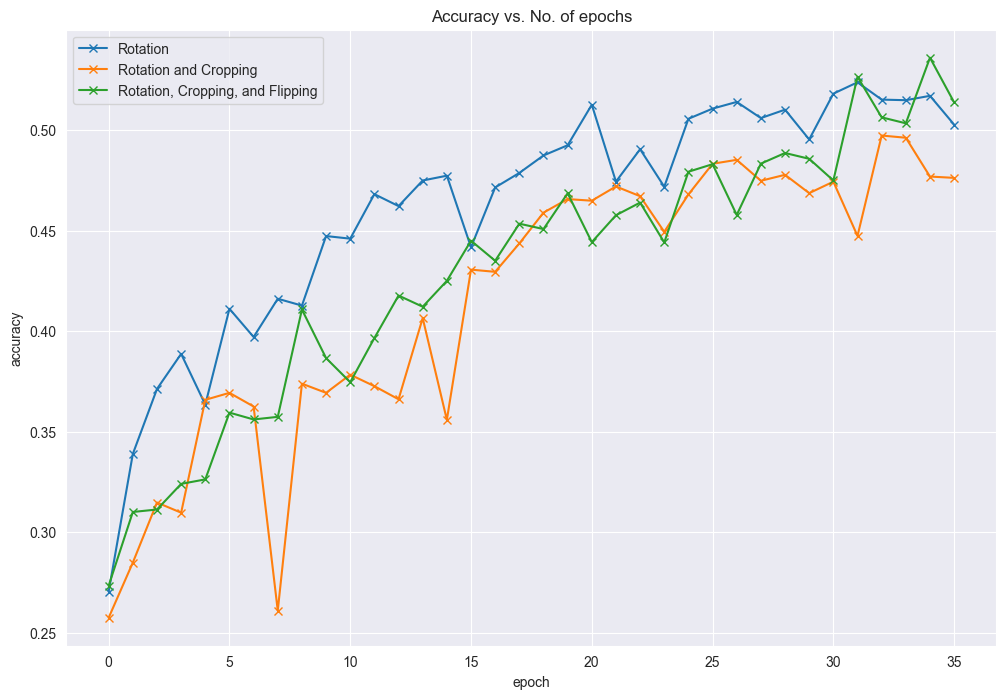

In [65]:
def plot_accuracies_refined(history1,history2,history3):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history1]
    plt.plot(accuracies, '-x', label = 'Rotation')
    accuracies = [x['val_acc'] for x in history2]
    plt.plot(accuracies, '-x', label = 'Rotation and Cropping')
    accuracies = [x['val_acc'] for x in history3]
    plt.plot(accuracies, '-x', label = 'Rotation, Cropping, and Flipping')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.legend()
    plt.rcParams["figure.figsize"] = (12,8)

plot_accuracies_refined(rotation_acc_history,Top2_acc_history,Top3_acc_history)

This plot shows that combining augmentation methods will not necessarily increase the initial accuracy of the model. However, the printed results show that mixing methods have larger training loss and are therefore less prone to overfitting.

## Conclusion

This report shows that data augmentation can greatly improve the accuracy of a model. The best preforming was model trained on the rotation transformation while the model trained on color jitter had the lowest accuracy. That being said the poor performance of color jitter may be the result of me choosing a poor range of parameters. Furthermore, I found that combining augmentation methods can help prevent overfitting. In the future I would like to experiment more with color jitter to find a range that only mildly affects the colors. For this study, even the best model has trouble classifying Plutues which was underrepresented in the full data set. Therefore, data augmentation will not make up for a unbalanced dataset.
